# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [61]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split,udf,sum 
#from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import isnan,when, count,desc,asc,round
from pyspark.sql.types import *

from pyspark.ml.linalg import Vectors 
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import Tokenizer,CountVectorizer, HashingTF, IDF, PCA 
from pyspark.ml.feature import VectorIndexer, OneHotEncoderEstimator, StopWordsRemover,VectorAssembler
from pyspark.ml.feature import StandardScaler,IndexToString, StringIndexer, MinMaxScaler
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.metrics import classification_report
from sklearn import preprocessing

from workspace_utils import active_session
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

import re
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from operator import add
from functools import reduce

spark = SparkSession.builder \
    .master("local") \
    .appName("Spark Capstone Project") \
    .getOrCreate()

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [62]:
mini_sparkify_event_data = 'mini_sparkify_event_data.json'
df = spark.read.json(mini_sparkify_event_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

First look at the data : - 

In [63]:
df.printSchema()
print(df.take(1))

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAge

Dropping Rows With Missing Items : - 

In [64]:
print("Total Count: ", df.count())
print("Missing Value in Columns :- ")
for colName, dtype in df.dtypes:
    print(colName,':', df.filter(df[colName].isNull()).count())

Total Count:  286500
Missing Value in Columns :- 
artist : 58392
auth : 0
firstName : 8346
gender : 8346
itemInSession : 0
lastName : 8346
length : 58392
level : 0
location : 8346
method : 0
page : 0
registration : 8346
sessionId : 0
song : 58392
status : 0
ts : 0
userAgent : 8346
userId : 0


As we can see:
1. userID, itemInSession, sessionID, time stamp,authorization, level, method and page has zero missing values. 

2. Artist, Length and Song have same number of missing values

3. User Agent, registration, first name, last name, location and gender have the same number of missing values. 

In [65]:
df.filter(df.registration.isNull()).show(1,False)

print("Number of rows with missing registration: ", df.filter(df.registration.isNull()).count())
print("Number of rows with missing registration, name, gender, location and user agent: ",\
      df.filter(df.registration.isNull() & df.firstName.isNull() & df.lastName.isNull() &
               df.gender.isNull() & df.location.isNull() & df.userAgent.isNull()).count()) 

df = df.filter(df.registration.isNotNull())

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|auth      |firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|ts           |userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|null  |Logged Out|null     |null  |100          |null    |null  |free |null    |GET   |Home|null        |8        |null|200   |1538355745000|null     |      |
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
only showing top 1 row

Number of rows with missing registration:  8346
Number of rows with missing registration, name, gender, location and user agent:  8346


These are all missing at the same row - where the user is not logged in. So as we can't identify these users individually and they constitute just ~3% of the records we drop the rows where registration is 0. 

Total Records : 286500

Missing Registration: 8346

% Missing Registration : 2.91%

Columns to Drop
- First name and last name aren't that useful
- Auth has no variability - all users are logged in 
- We can user id to uniquely identify a user - so registration number isn't needed
- All activities of a user will be collected without factoring in timestamp

In [66]:
dropIrrelevant = ["firstName","lastName","auth","ts","registration"]
keepCols = list(set(df.columns) - set(dropIrrelevant))
df = df.select(keepCols)
df.show(3,True)

+-------------+------+-----------------+--------+------+-----+--------------------+--------------------+---------+------+----------------+------+---------+
|itemInSession|gender|             song|    page|method|level|            location|           userAgent|   length|status|          artist|userId|sessionId|
+-------------+------+-----------------+--------+------+-----+--------------------+--------------------+---------+------+----------------+------+---------+
|           50|     M|        Rockpools|NextSong|   PUT| paid|     Bakersfield, CA|Mozilla/5.0 (Wind...|277.89016|   200|  Martha Tilston|    30|       29|
|           79|     M|           Canada|NextSong|   PUT| free|Boston-Cambridge-...|"Mozilla/5.0 (Win...|236.09424|   200|Five Iron Frenzy|     9|        8|
|           51|     M|Time For Miracles|NextSong|   PUT| paid|     Bakersfield, CA|Mozilla/5.0 (Wind...| 282.8273|   200|    Adam Lambert|    30|       29|
+-------------+------+-----------------+--------+------+-----+--

In [67]:
print("Number of rows with missing artist: ", df.filter(df.artist.isNull()).count())
print("Number of rows with missing artist, song, song length in same row: ",\
      df.filter(df.artist.isNull() & df.song.isNull() & df.length.isNull()).count()) 

print("Next song page with missing song: ", df.filter(df.song.isNull() & (df.page=="NextSong")).count()) 
print("Song on a different page: ", df.filter(df.song.isNotNull() & (df.page!="NextSong")).count()) 

Number of rows with missing artist:  50046
Number of rows with missing artist, song, song length in same row:  50046
Next song page with missing song:  0
Song on a different page:  0


When we look into song which has same missing values as length and artist we find, 

When song is null, length is not defined as well as artist. Song is only present on the page nextSong.

Total Records : 286500

Missing Song (not a song page): 58392

% Missing Registration : 20.38 %

20% rows do not contain songs but these other pages can be relevant in determining churn so we will use it later, instead of dropping it.  

In [68]:
df.groupby('level','page').count().sort('page').show(100,False)
df.groupby('page','method').count().sort('page','method').show(100,False)

+-----+-------------------------+------+
|level|page                     |count |
+-----+-------------------------+------+
|free |About                    |93    |
|paid |About                    |402   |
|free |Add Friend               |893   |
|paid |Add Friend               |3384  |
|paid |Add to Playlist          |5354  |
|free |Add to Playlist          |1172  |
|paid |Cancel                   |31    |
|free |Cancel                   |21    |
|free |Cancellation Confirmation|21    |
|paid |Cancellation Confirmation|31    |
|paid |Downgrade                |2055  |
|free |Error                    |53    |
|paid |Error                    |199   |
|paid |Help                     |1132  |
|free |Help                     |322   |
|paid |Home                     |7461  |
|free |Home                     |2621  |
|free |Logout                   |922   |
|paid |Logout                   |2304  |
|free |NextSong                 |41991 |
|paid |NextSong                 |186117|
|paid |Roll Adve

Looking into pages column : 
    
Free users can reach upgrade and submit upgrade page  
Paid users can reach downgrade and submit downgrade page    

The remaining pages are common. A page has either GET or POST method not both. 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [69]:
df = df.na.fill(0)

#REMOVE WHITE SPACES
@F.udf
def removeSpace(x):
    x = x.replace(' ', '')
    return x

#MAKE CATEGORICAL
@F.udf
def getBinary(x,val):
    if x==val:
        return 1
    return 0

df = df.withColumn('page',removeSpace('page')) 
pages = set()
pagesList = df.select('page').collect()
removePage = ['Cancel','CancellationConfirmation'] #remove cancel also

for page in pagesList:
    page = page.__getitem__("page")
    pages.add(page)

for page in list(pages):
    df = df.withColumn('page_'+page,getBinary('page',lit(page)))

df = df.withColumn('churn',reduce(add,[F.col("page_"+x) for x in removePage]))

for page in removePage:
    pages.remove(page)
    df = df.drop("page_"+page)

print(df.columns)

['itemInSession', 'gender', 'song', 'page', 'method', 'level', 'location', 'userAgent', 'length', 'status', 'artist', 'userId', 'sessionId', 'page_ThumbsDown', 'page_Help', 'page_Home', 'page_Logout', 'page_AddFriend', 'page_SubmitUpgrade', 'page_AddtoPlaylist', 'page_ThumbsUp', 'page_Downgrade', 'page_SubmitDowngrade', 'page_SaveSettings', 'page_RollAdvert', 'page_Upgrade', 'page_NextSong', 'page_Error', 'page_About', 'page_Settings', 'churn']


### Defining Churn

In each page column - 0 indicates the event did not happen on this page, 1 indicates the event happened on this page

I've defined churn as if the user reaches Cancel or Cancellation Confirmation. This means they have left the platform. Reaching Cancellation Confirmation requires reaching Cancel page, so let's see if we can determine churn using other features. 


Many features can't be grouped as is, so I will do some feature transformation first. All the events of a user have to be accumulated to describe the user.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Agents
The information isn't presented in a manner easy to accumulate. Here, the agent into one of four categories :
- Linux OS
- Windows OS
- MAC OSX
- Apple phone

In [70]:
@F.udf
def countAgent(x):
    x = str.lower(x)
    if "linux" in x:
        return "LINUX"
    if "windows" in x:
        return "WINDOWS"
    if "iphone" in x:
        return "IPHONE"
    return "MAC"

df.select('userAgent').groupby('userAgent').count().show(10,False)
df = df.withColumn('userAgent',countAgent('userAgent'))
df.groupby('userAgent').count().show()

+--------------------------------------------------------------------------------------------------------------------------+-----+
|userAgent                                                                                                                 |count|
+--------------------------------------------------------------------------------------------------------------------------+-----+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|240  |
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                  |5238 |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                |62   |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|18448|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Ge

### Location
There are users over various locations in the USA. The state can be identified from the location. The user can be put into a region based on the state
- North-East
- South
- West
- MidWest

In [71]:
@F.udf
def getStates(x):
    x = x.replace(" ", "")
    x = x.split(',')
    return x[-1]

@F.udf
def getRegion(x):
    x = x.split('-')
    x = x[0]
    if x in ['NY','NJ','PA','NH','CT', 'ME','MA','RI','VT']:
        return "NORTHEAST"
    if x in ['DE','FL','GA','MD','NC','SC','VA','DC','WV','AL',
             'KY','MS','TN','AR','LA','OK','TX']:
        return "SOUTH"
    if x in ['AK','CA','WA','OR', 'HI','ID','MT','UT','AZ',
             'CO','NV','NM','WY']:
        return "WEST"
    if x in ['IN', 'IL','MI', 'MN','MO', 'WI','OH','IA','NE',
             'WI','KS','ND','SD']:
        return "MIDWEST"
    return "NORTHEAST"

df = df.withColumn('location',getStates('location'))
df.groupby('location').count().show(10,False)
df = df.withColumn('location',getRegion('location'))
df.groupby('location').count().show()

+--------+-----+
|location|count|
+--------+-----+
|UT-ID   |317  |
|AZ      |4846 |
|SC      |668  |
|GA-AL   |2716 |
|LA      |1171 |
|RI-MA   |927  |
|NJ      |7001 |
|IL-MO   |1003 |
|MN-WI   |2241 |
|OR      |23   |
+--------+-----+
only showing top 10 rows

+---------+------+
| location| count|
+---------+------+
|     WEST| 72434|
|  MIDWEST| 32058|
|    SOUTH|102529|
|NORTHEAST| 71133|
+---------+------+



### Successfuly Loaded Pages

There can be several http status codes. Code 200 is success and anything else means the page isn't accessible - which could cause users to churn. That is why the status code is transformed so 1 represents a succesful page hit and 0 is a failure. As we can see most pages are successful. There are quite a large number of status 307) URL moved though

In [72]:
df.groupby('status').count().show()

df = df.withColumn('status200',getBinary('status',lit(200)))
df = df.withColumn('status307',getBinary('status',lit(307)))

+------+------+
|status| count|
+------+------+
|   307| 23184|
|   404|   252|
|   200|254718|
+------+------+



### Aggregating User Data

Now we can finally group the data based on the user and account type combination. We group on two levels as a persons behaviour can be different based on which mode of subscription they have at the moment. 
- Artists are aggregated
- Numeric columns are summed up (with the exception of song length - we take average)
- Max is taken of the categoric column, many columns don't have variability over user. Example: gender, location. Also, churn must be taken as 1 if any event leads to a churn

In [73]:
DF = df.groupby('userId','level').agg(sum("status200").alias('status200'),
                                      sum("status307").alias('status307'),\
                                      avg('length').alias('avgLength'),\
                                      max("gender").alias('gender'),\
                                      max("location").alias('location'),\
                                      max("userAgent").alias('userAgent'),\
                                      count("*").alias('totalPages'),\
                                      sum("page_ThumbsDown").alias("page_ThumbsDown"),\
                                      sum("page_SubmitUpgrade").alias("page_SubmitUpgrade"),\
                                      sum("page_Upgrade").alias("page_Upgrade"),\
                                      sum("page_Help").alias("page_Help"),\
                                      sum("page_Logout").alias("page_Logout"),\
                                      sum("page_AddtoPlaylist").alias("page_AddtoPlaylist"),\
                                      sum("page_AddFriend").alias("page_AddFriend"),\
                                      sum("page_RollAdvert").alias("page_RollAdvert"),\
                                      sum("page_About").alias("page_About"),\
                                      sum("page_Downgrade").alias("page_Downgrade"),\
                                      sum("page_SubmitDowngrade").alias("page_SubmitDowngrade"),\
                                      sum("page_NextSong").alias("page_NextSong"),\
                                      sum("page_Home").alias("page_Home"),\
                                      sum("page_SaveSettings").alias("page_SaveSettings"),\
                                      sum("page_Error").alias("page_Error"),\
                                      sum("page_ThumbsUp").alias("page_ThumbsUp"),\
                                      sum("page_Settings").alias("page_Settings"),\
                                      max("churn").alias('churn')).sort('userId') # NEW DATAFRAME

Let's also create one more feature - ratio of positive thumbsup to negative thumbsup. To see how users are liking the songs.

In [79]:
#DIVIDE COLS
@F.udf
def getRatio(x,y):
    x = float(x)
    y = float(y)
    if (x+y) == 0:
        return 0
    return x/(x+y)

DF = DF.withColumn('positiveThumbs',getRatio('page_Thumbsup','page_ThumbsDown'))
DF = DF.withColumn('positiveThumbs', DF['positiveThumbs'].cast(DoubleType()))

In [81]:
DF.select(min('positiveThumbs').alias("minRatio"),round(avg('positiveThumbs'),3).alias("avgRatio"),max('positiveThumbs').alias("maxRatio")).show()

+--------+--------+--------+
|minRatio|avgRatio|maxRatio|
+--------+--------+--------+
|     0.0|   0.786|     1.0|
+--------+--------+--------+



In [82]:
display(DF.head(1))
DF.select(DF.columns).write.mode("overwrite").save("DataFrameF.parquet")

[Row(userId='10', level='paid', status200=730.0, status307=65.0, avgLength=209.8948081886793, gender='M', location='SOUTH', userAgent='MAC', totalPages=795, page_ThumbsDown=4.0, page_SubmitUpgrade=0.0, page_Upgrade=0.0, page_Help=1.0, page_Logout=11.0, page_AddtoPlaylist=9.0, page_AddFriend=12.0, page_RollAdvert=1.0, page_About=2.0, page_Downgrade=7.0, page_SubmitDowngrade=0.0, page_NextSong=673.0, page_Home=30.0, page_SaveSettings=1.0, page_Error=0.0, page_ThumbsUp=37.0, page_Settings=7.0, churn=0.0, positiveThumbs=0.9024390243902439)]

Column:  level


/opt/conda/lib/python3.6/site-packages/pandas/plotting/_core.py:2120: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  yrot=yrot, **kwds)


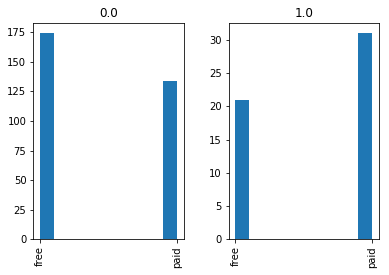

Column:  status200


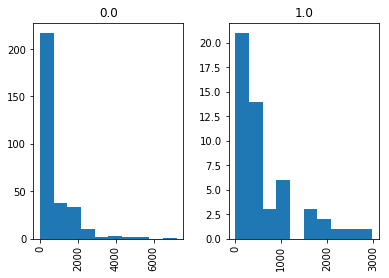

Column:  status307


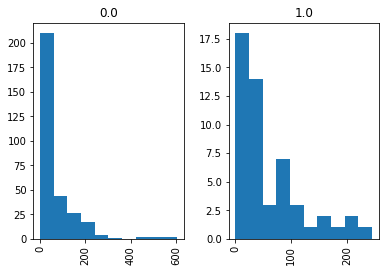

Column:  avgLength


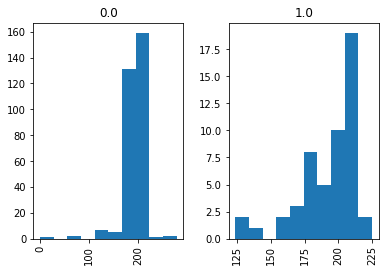

Column:  gender


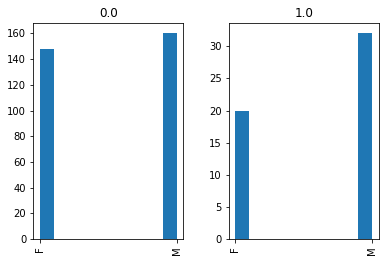

Column:  location


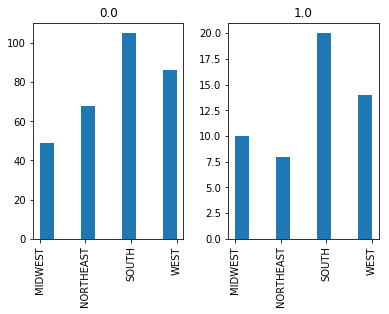

Column:  userAgent


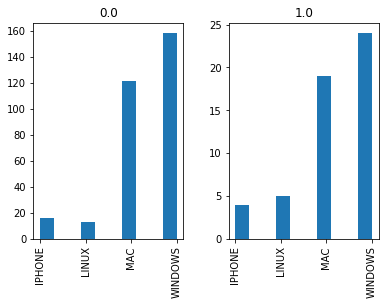

Column:  totalPages


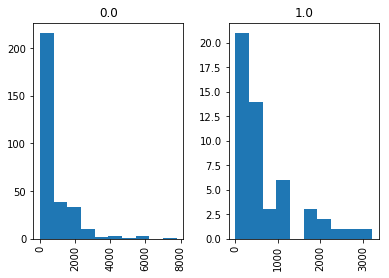

Column:  page_ThumbsDown


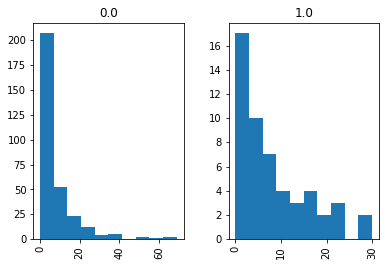

Column:  page_SubmitUpgrade


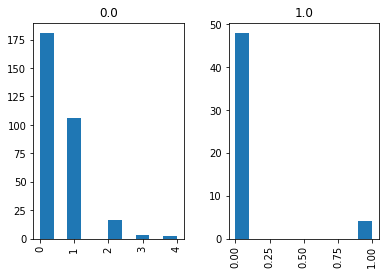

Column:  page_Upgrade


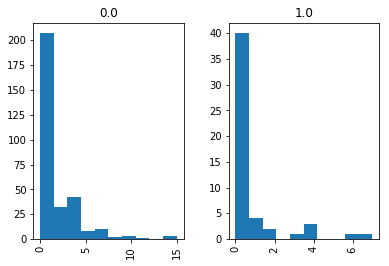

Column:  page_Help


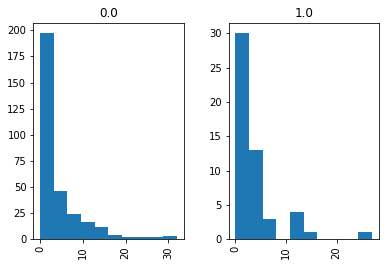

Column:  page_Logout


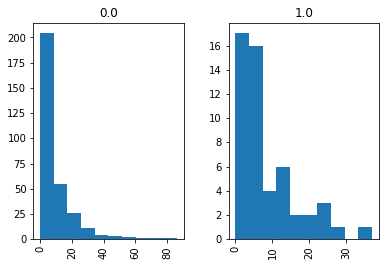

Column:  page_AddtoPlaylist


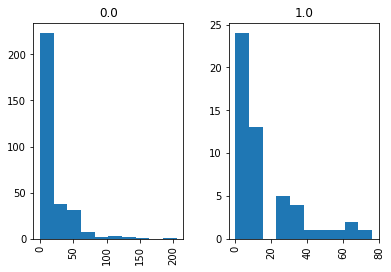

Column:  page_AddFriend


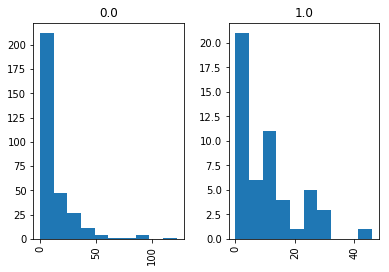

Column:  page_RollAdvert


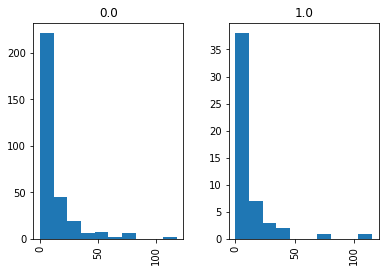

Column:  page_About


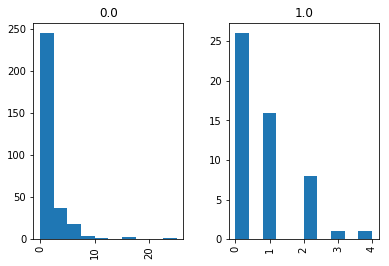

Column:  page_Downgrade


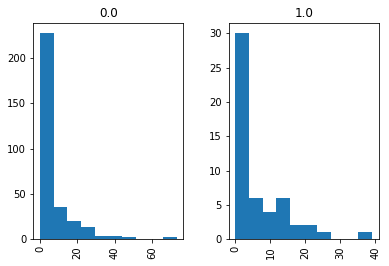

Column:  page_SubmitDowngrade


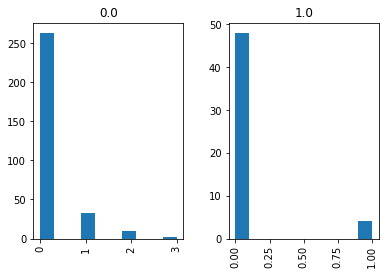

Column:  page_NextSong


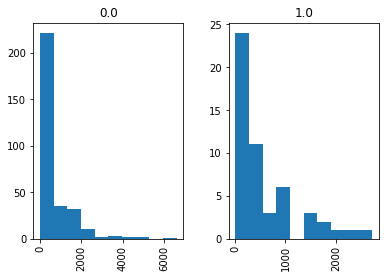

Column:  page_Home


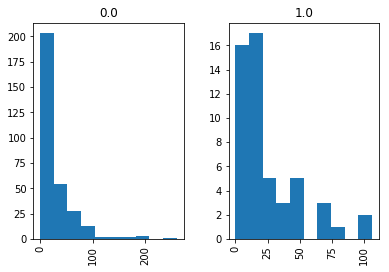

Column:  page_SaveSettings


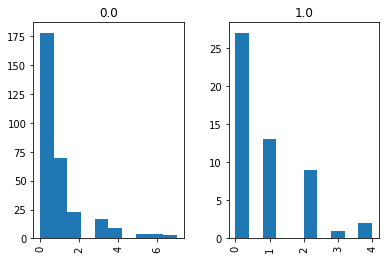

Column:  page_Error


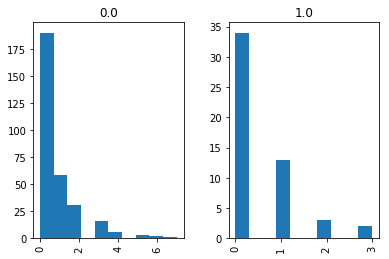

Column:  page_ThumbsUp


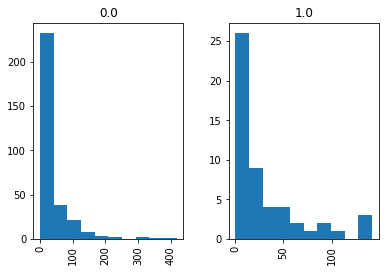

Column:  page_Settings


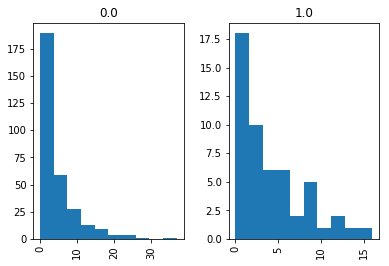

Column:  positiveThumbs


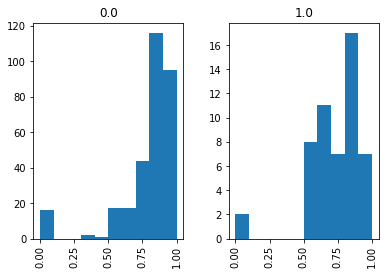

Column:  status200


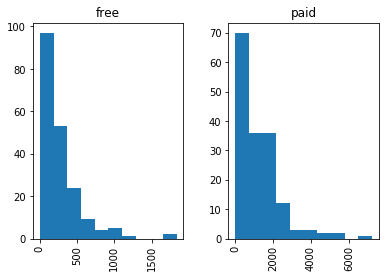

Column:  status307


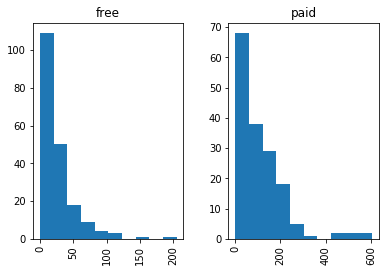

Column:  avgLength


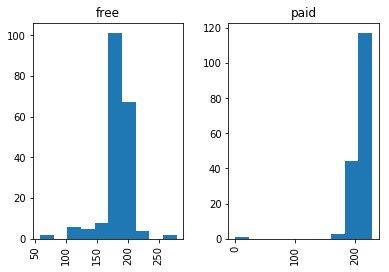

Column:  gender


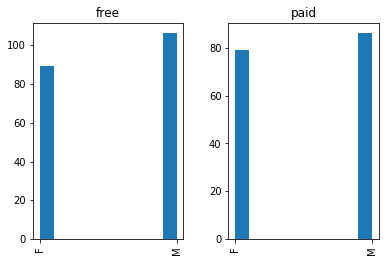

Column:  location


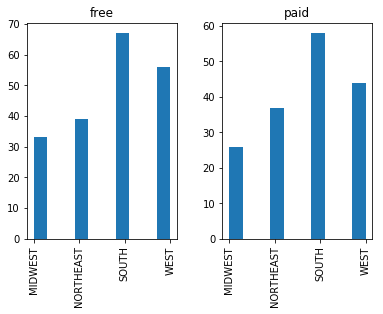

Column:  userAgent


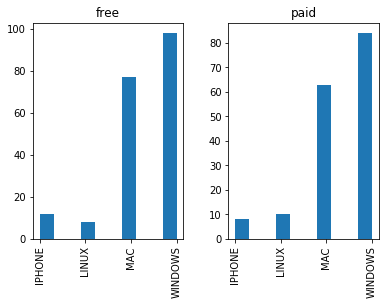

Column:  totalPages


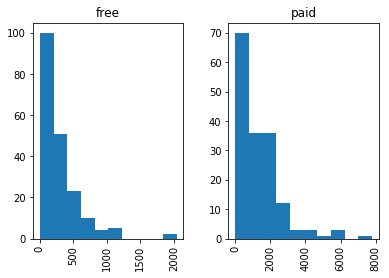

Column:  page_ThumbsDown


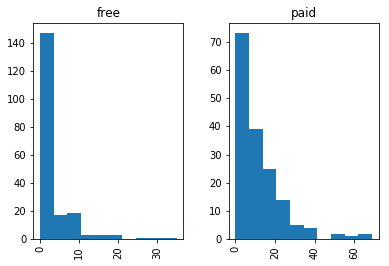

Column:  page_SubmitUpgrade


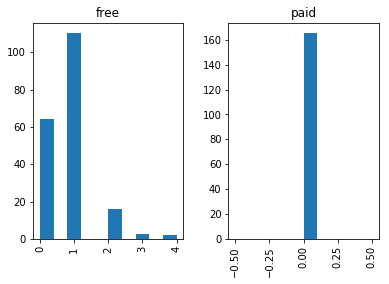

Column:  page_Upgrade


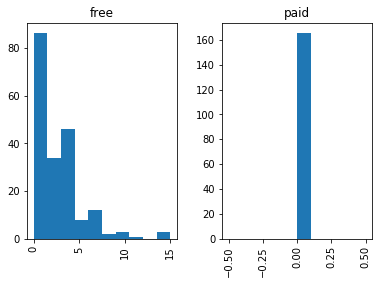

Column:  page_Help


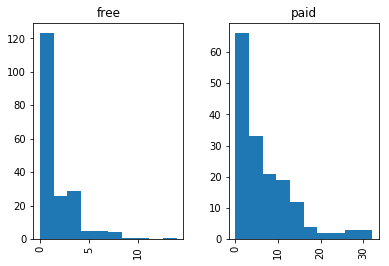

Column:  page_Logout


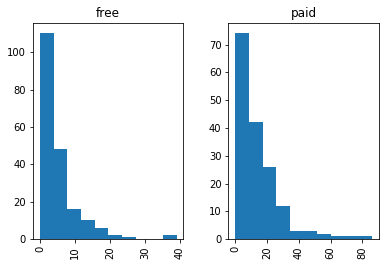

Column:  page_AddtoPlaylist


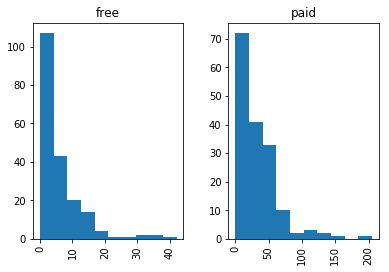

Column:  page_AddFriend


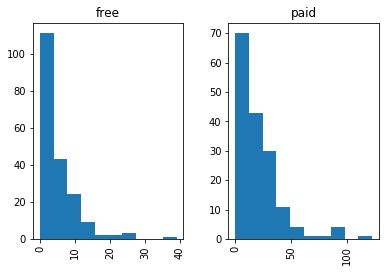

Column:  page_RollAdvert


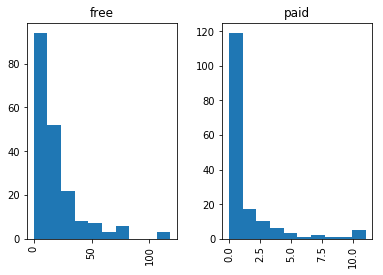

Column:  page_About


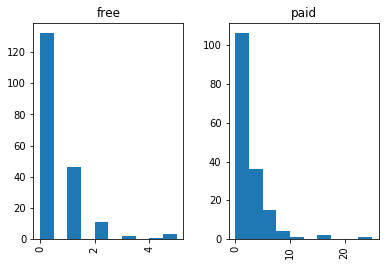

Column:  page_Downgrade


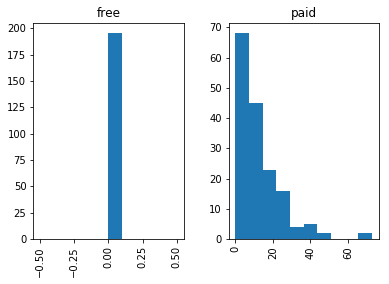

Column:  page_SubmitDowngrade


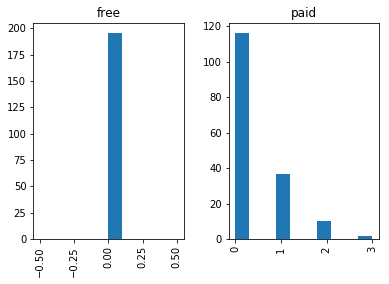

Column:  page_NextSong


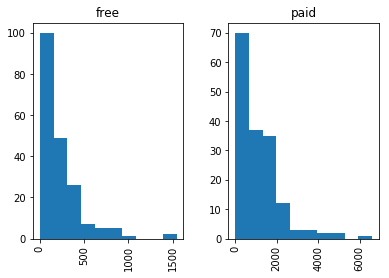

Column:  page_Home


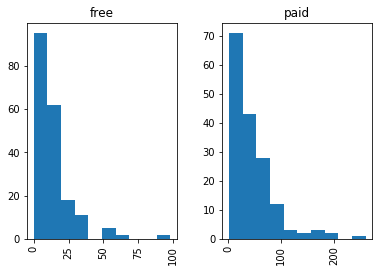

Column:  page_SaveSettings


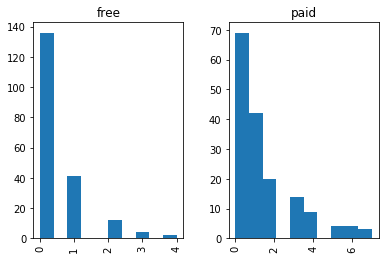

Column:  page_Error


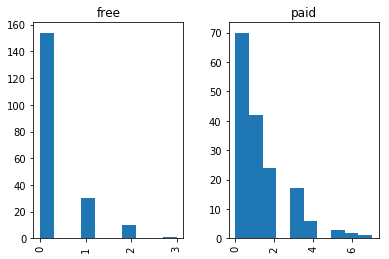

Column:  page_ThumbsUp


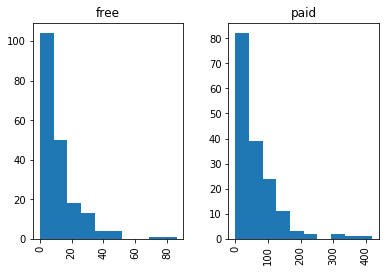

Column:  page_Settings


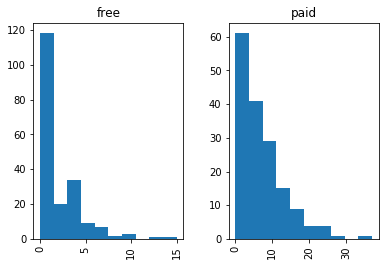

Column:  churn


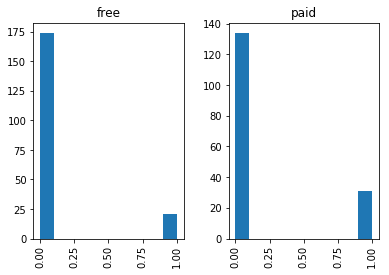

Column:  positiveThumbs


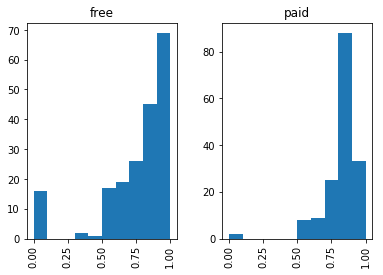

In [83]:
DF_pandas = DF.toPandas()

for col in DF_pandas.columns:
    if col in ['userId','churn']:
        continue
    print('Column: ',col)
    
    fig, ax = plt.subplots()
    DF_pandas.hist(column=col,by=DF_pandas.churn,ax=ax)
    
    plt.show()
    
for col in DF_pandas.columns:
    if col in ['userId','level']:
        continue
    print('Column: ',col)
    
    fig, ax = plt.subplots()
    DF_pandas.hist(column=col,by=DF_pandas.level,ax=ax)    
    plt.show()

PROBLEM COLUMN:  level


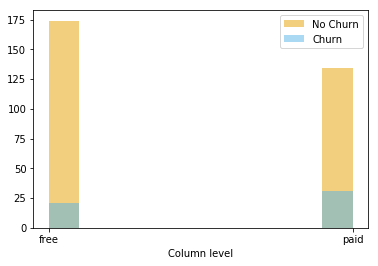

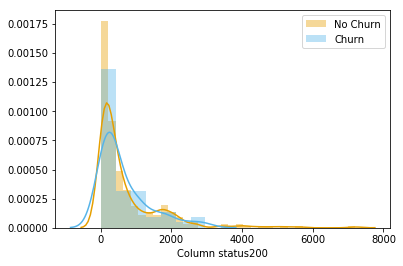

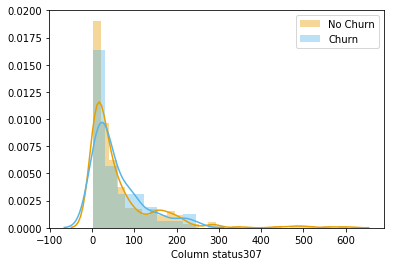

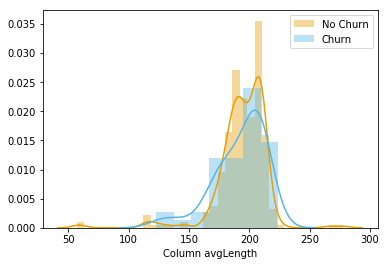

PROBLEM COLUMN:  gender


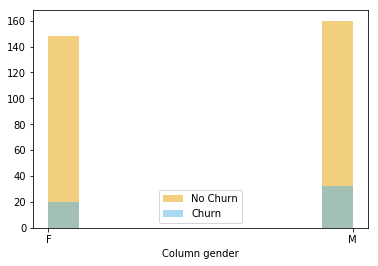

PROBLEM COLUMN:  location


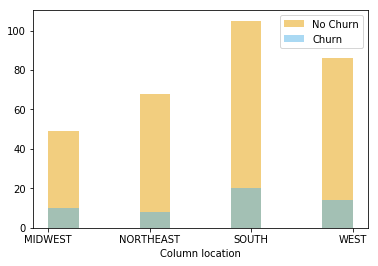

PROBLEM COLUMN:  userAgent


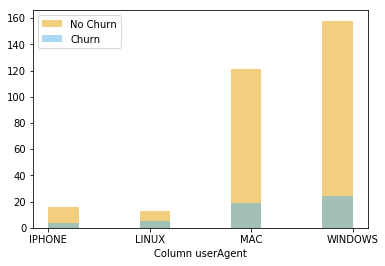

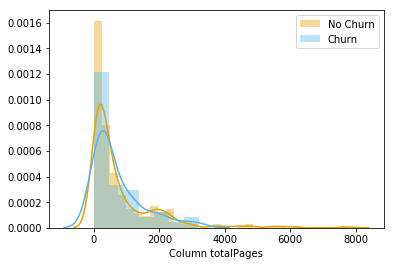

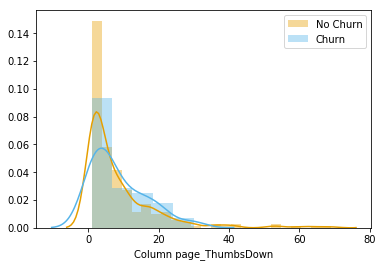

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


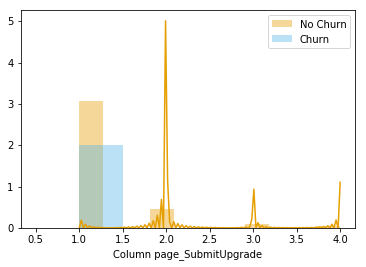

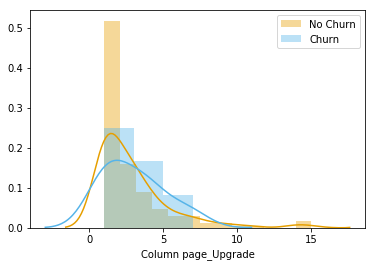

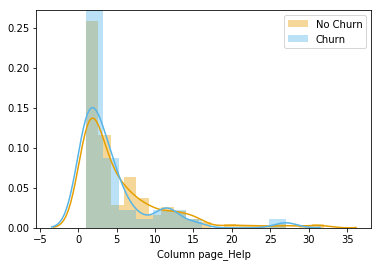

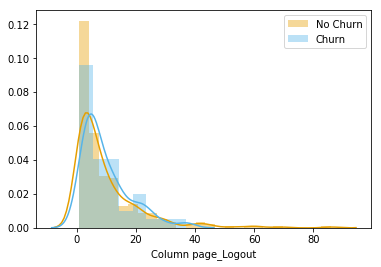

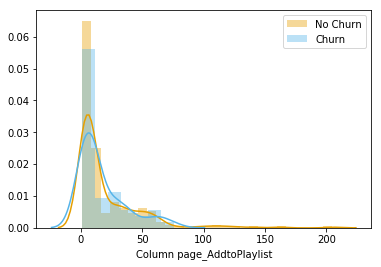

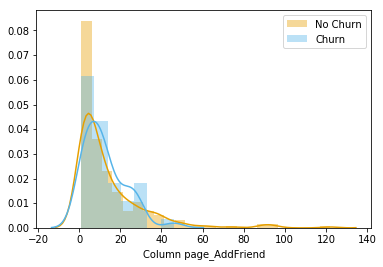

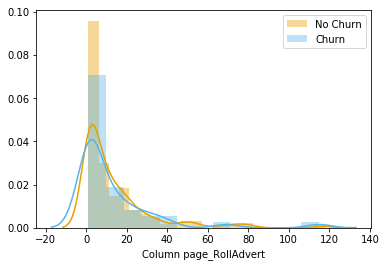

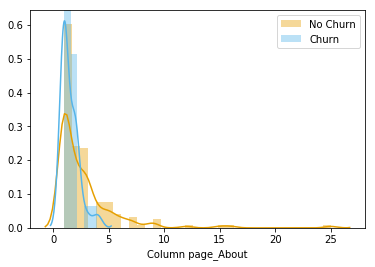

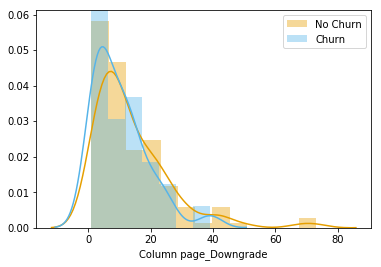

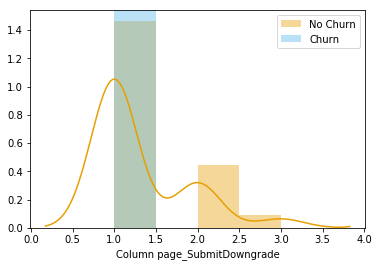

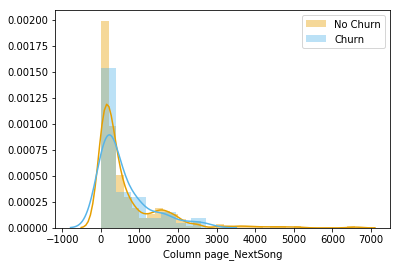

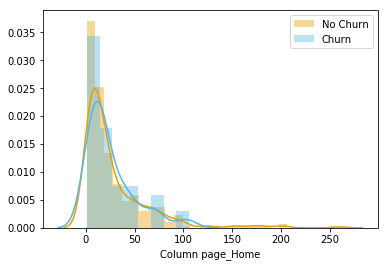

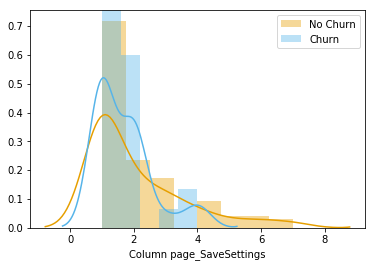

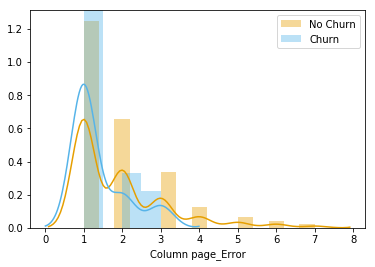

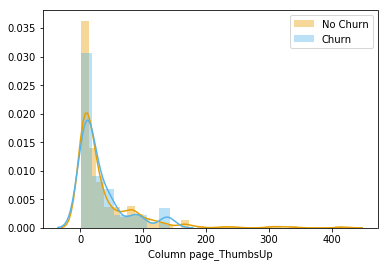

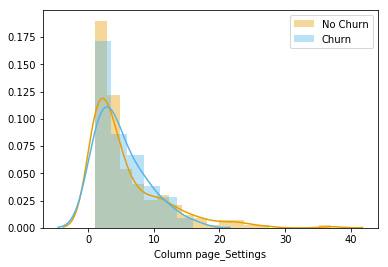

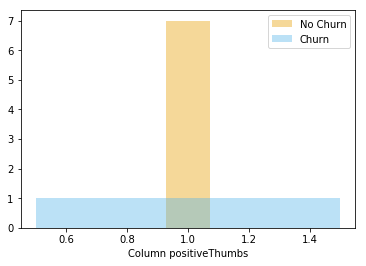

In [84]:
for col in DF_pandas.columns:
    if col in ['userId','churn']:
        continue
    x1 = list(DF_pandas[DF_pandas['churn'] == 0][col])
    x2 = list(DF_pandas[DF_pandas['churn'] == 1][col])

    colors = ['#E69F00', '#56B4E9']
    names = ['No Churn','Churn']
    try:
        a = int(x1[0])
        x1 = [int(x) for x in x1]
        x2 = [int(x) for x in x2]
        #try removing 0's
        x1 = [x for x in x1 if x != 0]
        x2 = [x for x in x2 if x != 0]
        sns.distplot(x1,color = colors[0], label=names[0])
        sns.distplot(x2,color = colors[1], label=names[1])
       
    except ValueError:
        print("PROBLEM COLUMN: ",col)
        x1 = list(DF_pandas[DF_pandas['churn'] == 0][col])
        x2 = list(DF_pandas[DF_pandas['churn'] == 1][col])
        plt.hist(x1, color = colors[0],alpha=0.5,label=names[0])
        plt.hist(x2, color = colors[1],alpha=0.5,label=names[1])
    plt.legend()
    plt.xlabel("Column "+col)
    plt.show()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [85]:
DF = spark.read.load("./DataFrameF.parquet")
display(DF.head(1))

[Row(userId='300024', level='paid', status200=93.0, status307=9.0, avgLength=222.5357271568627, gender='F', location='WEST', userAgent='MAC', totalPages=102, page_ThumbsDown=0.0, page_SubmitUpgrade=0.0, page_Upgrade=0.0, page_Help=0.0, page_Logout=1.0, page_AddtoPlaylist=2.0, page_AddFriend=2.0, page_RollAdvert=0.0, page_About=0.0, page_Downgrade=0.0, page_SubmitDowngrade=0.0, page_NextSong=88.0, page_Home=2.0, page_SaveSettings=0.0, page_Error=0.0, page_ThumbsUp=6.0, page_Settings=1.0, churn=0.0, positiveThumbs=1.0)]

### PCA

First let's do PCA on the numerical components. A solid amount of variance can be captured by a smaller number of uncorrelated transfomed features. 

In [88]:
Pages = [("page_"+ page) for page in pages]
numericColumns = Pages + ['totalPages','avgLength', 'positiveThumbs','status200','status307']

k  = len(numericColumns)
print("K: ", k)
stagesPCA = []
assembler = VectorAssembler(inputCols=numericColumns, outputCol="numericAssemble")
scaler = StandardScaler(inputCol="numericAssemble", outputCol="stdNumeric",withStd=True, withMean=False)
pca = PCA(k=k, inputCol="stdNumeric", outputCol="PCANumeric")
stagesPCA += [assembler,scaler,pca]
pipelinePCA = Pipeline(stages=stagesPCA)
modelFit = pipelinePCA.fit(DF) 
var = modelFit.stages[-1].explainedVariance
print(var) 
cumVar = 0
for k, kVar in enumerate(var):
    cumVar += kVar
    print("K: ", k, ", Var: ", kVar,", CumVar: ",cumVar)

K:  22
[0.636123213768,0.114324967213,0.0554580960235,0.0385625547629,0.0299730227088,0.0255502650699,0.0238567310238,0.0191117898114,0.0143116421476,0.0102211260045,0.00803636381377,0.00682252872014,0.00507476359412,0.00413725322462,0.00340168694794,0.00242128872018,0.0015740599284,0.000600063656035,0.000438131364759,4.51496344826e-07,8.15045254355e-18,1.85093583211e-18]
K:  0 , Var:  0.636123213768 , CumVar:  0.636123213768
K:  1 , Var:  0.114324967213 , CumVar:  0.750448180981
K:  2 , Var:  0.0554580960235 , CumVar:  0.805906277005
K:  3 , Var:  0.0385625547629 , CumVar:  0.844468831768
K:  4 , Var:  0.0299730227088 , CumVar:  0.874441854477
K:  5 , Var:  0.0255502650699 , CumVar:  0.899992119546
K:  6 , Var:  0.0238567310238 , CumVar:  0.92384885057
K:  7 , Var:  0.0191117898114 , CumVar:  0.942960640382
K:  8 , Var:  0.0143116421476 , CumVar:  0.957272282529
K:  9 , Var:  0.0102211260045 , CumVar:  0.967493408534
K:  10 , Var:  0.00803636381377 , CumVar:  0.975529772347
K:  11 , V

We will try using k = 6,7,8,9 
- K = 6 . Here, each component explains >=2% of variance and total variance explained is about 92.38%
- K = 9 . Here, each component explains >=1% of variance and total variance explained is about 96.75%
 
After, selecting the transformed features we are ready to employ different types of modelling methods. 

### 1. Random Forest

In [89]:
Pages = [("page_"+ page) for page in pages]
numericColumns = Pages + ['totalPages','avgLength', 'positiveThumbs','status200','status307']
categoricalColumns = ['gender','location','userAgent','level'] 
stagesRF = []
##category
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "_vec"])
    stagesRF += [stringIndexer, encoder]

##numbers
assembler = VectorAssembler(inputCols=numericColumns, outputCol="numericAssemble")
scaler = MinMaxScaler(inputCol="numericAssemble", outputCol="stdNumeric") #,withStd=True, withMean=False)
pca = PCA(inputCol="stdNumeric", outputCol="PCANumeric")
stagesRF += [assembler,scaler,pca]

##label
label_index = StringIndexer(inputCol = 'churn', outputCol = 'label')
stagesRF += [label_index]

##assembler, features
assemblerInputs =  [cat + "_vec" for cat in categoricalColumns]+ ["PCANumeric"]
assemblerFinal = VectorAssembler(inputCols=assemblerInputs,outputCol="features") 

##model
rf = RandomForestClassifier()#numtrees=10 
stagesRF += [assemblerFinal,rf]

##params
paramGrid = ParamGridBuilder() \
    .addGrid(pca.k,[6,7,8,9]) \
    .addGrid(rf.numTrees,[1,2,4,8,16]) \
    .addGrid(rf.maxDepth,[2,4,8,16]) \
    .build()

#training now
trainingData, testData = DF.randomSplit([0.7, 0.3])
trainingData.cache()

with active_session():
    RFCrossVal = CrossValidator(estimator=Pipeline(stages=stagesRF),\
                          estimatorParamMaps=paramGrid,\
                          numFolds=5,\
                          evaluator=MulticlassClassificationEvaluator())
    RFModel = RFCrossVal.fit(trainingData)
    bestRFModel = RFModel.bestModel
    bestRFModel.save('./FinalRFModel')
    RFResults = RFModel.transform(testData)

In [90]:
tp = RFResults.filter((RFResults.label == 1.0) & (RFResults.prediction == 1.0)).count()
fp = RFResults.filter((RFResults.label == 0.0) & (RFResults.prediction == 1.0)).count()
tn = RFResults.filter((RFResults.label == 0.0) & (RFResults.prediction == 0.0)).count()
fn = RFResults.filter((RFResults.label == 1.0) & (RFResults.prediction == 0.0)).count()

print("True Positives:", tp)
print("False Negatives:", fn)
print("True Negatives:", tn)
print("False Positives:", fp)

print("Accuracy: ", (tp+tn)/(tp+fp+tn+fn))

precision, recall = 0,0
if (tp+fp) > 0:
    precision = (tp)/(tp+fp)
    print("Precision: ", precision)
else:
    print("Precision is undefined.")
if (tp+fn) > 0:
    recall = (tp)/(tp+fn)
    print("Recall: ", recall)
else:
    print("Recall is undefined.")
if (precision==0) or (recall==0):
    print("F1 is undefined.")
else:
    print("F1:", 2*(precision*recall)/(precision+recall))

True Positives: 1
False Negatives: 17
True Negatives: 83
False Positives: 1
Accuracy:  0.8235294117647058
Precision:  0.5
Recall:  0.05555555555555555
F1: 0.09999999999999999


In [91]:
lab = list(RFResults.select('label').toPandas()['label'])
pred = list(RFResults.select('prediction').toPandas()['prediction'])
print(classification_report(lab,pred,target_names=['No Churn', 'Churn']))

             precision    recall  f1-score   support

   No Churn       0.83      0.99      0.90        84
      Churn       0.50      0.06      0.10        18

avg / total       0.77      0.82      0.76       102



Only one positive churn label was identified correctly. There was one false positive as well. 

### 2. Logistic Regression

In [92]:
Pages = [("page_"+ page) for page in pages]
numericColumns = Pages + ['totalPages','avgLength', 'positiveThumbs','status200','status307']
categoricalColumns = ['gender','location','userAgent','level'] 
stagesLR = []

##category
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "_vec"])
    stagesLR += [stringIndexer, encoder]

##numbers
assembler = VectorAssembler(inputCols=numericColumns, outputCol="numericAssemble")
scaler = StandardScaler(inputCol="numericAssemble", outputCol="stdNumeric")
pca = PCA(inputCol="stdNumeric", outputCol="PCANumeric")
stagesLR += [assembler,scaler,pca]

##label
label_index = StringIndexer(inputCol = 'churn', outputCol = 'label')
stagesLR += [label_index]

##assembler, features
assemblerInputs =  [cat + "_vec" for cat in categoricalColumns]+ ["PCANumeric"]
assembler2 = VectorAssembler(inputCols=assemblerInputs,outputCol="features") 

##model
lr = LogisticRegression(maxIter=20,family="binomial")#numtrees=10 

##params
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 0.8]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .addGrid(pca.k,[6,7,8,9])\
    .build()

stagesLR += [assembler2,lr]

#training now
trainingData, testData = DF.randomSplit([0.7, 0.3])
trainingData.cache()

LRCrossVal = CrossValidator(estimator=Pipeline(stages=stagesLR),\
                          estimatorParamMaps=paramGrid,\
                          numFolds=3,\
                          evaluator=BinaryClassificationEvaluator())

with active_session():
    LRModel = LRCrossVal.fit(trainingData)
    bestLRModel = LRModel.bestModel
    bestLRModel.save('./Final_LRModel')

In [93]:
LRResults = LRModel.transform(testData)

tp = LRResults.filter((LRResults.label == 1.0) & (LRResults.prediction == 1.0)).count()
fp = LRResults.filter((LRResults.label == 0.0) & (LRResults.prediction == 1.0)).count()
tn = LRResults.filter((LRResults.label == 0.0) & (LRResults.prediction == 0.0)).count()
fn = LRResults.filter((LRResults.label == 1.0) & (LRResults.prediction == 0.0)).count()

print("True Positives:", tp)
print("False Negatives:", fn)
print("True Negatives:", tn)
print("False Positives:", fp)


print("Accuracy: ", (tp+tn)/(tp+fp+tn+fn))

precision, recall = 0,0
if (tp+fp) > 0:
    precision = (tp)/(tp+fp)
    print("Precision: ", precision)
else:
    print("Precision is undefined.")
if (tp+fn) > 0:
    recall = (tp)/(tp+fn)
    print("Recall: ", recall)
else:
    print("Recall is undefined.")
if (precision==0) or (recall==0):
    print("F1 is undefined.")
else:
    print("F1:", 2*(precision*recall)/(precision+recall))

True Positives: 1
False Negatives: 12
True Negatives: 93
False Positives: 0
Accuracy:  0.8867924528301887
Precision:  1.0
Recall:  0.07692307692307693
F1: 0.14285714285714288


### 2.1. Adjusting Threshold of Model
Only one positive churn was identified correctly with simple logistic regression. Let us adjust threshold of the best Logistic Regression model to maximise F-measure

In [95]:
trainingSummary = bestLRModel.stages[-1].summary
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']

print("Best threshold: ", bestThreshold)

bestLRModel.stages[-1]._java_obj.setThreshold(bestThreshold)
bestLRModel.save('./Final_LR_withThresholdModel')

+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|                 0.0|0.05128205128205128|
|0.009302325581395349|0.05128205128205128|
|0.013953488372093023|0.07692307692307693|
|0.013953488372093023| 0.1282051282051282|
|0.023255813953488372| 0.1282051282051282|
|0.027906976744186046|0.15384615384615385|
|0.037209302325581395|0.15384615384615385|
|0.037209302325581395|0.20512820512820512|
| 0.04186046511627907|0.23076923076923078|
| 0.05116279069767442|0.23076923076923078|
| 0.05581395348837209| 0.2564102564102564|
| 0.06511627906976744| 0.2564102564102564|
| 0.06976744186046512|0.28205128205128205|
| 0.06976744186046512| 0.3333333333333333|
| 0.07441860465116279|  0.358974358974359|
| 0.07441860465116279|0.41025641025641024|
| 0.08372093023255814|0.41025641025641024|
| 0.08837209302325581| 0.4358974358974359|
| 0.09302325581395349|0.46153846153846156|
+----------

In [99]:
trainingData, testData = DF.randomSplit([0.7, 0.3])
trainingData.cache()

LRThreshResults = bestLRModel.transform(testData)

tp = LRThreshResults.filter((LRThreshResults.label == 1.0) & (LRThreshResults.prediction == 1.0)).count()
fp = LRThreshResults.filter((LRThreshResults.label == 0.0) & (LRThreshResults.prediction == 1.0)).count()
tn = LRThreshResults.filter((LRThreshResults.label == 0.0) & (LRThreshResults.prediction == 0.0)).count()
fn = LRThreshResults.filter((LRThreshResults.label == 1.0) & (LRThreshResults.prediction == 0.0)).count()

print("True Positives:", tp)
print("False Negatives:", fn)
print("True Negatives:", tn)
print("False Positives:", fp)

print("Accuracy: ", (tp+tn)/(tp+fp+tn+fn))

precision, recall = 0,0

if (tp+fp) > 0:
    precision = (tp)/(tp+fp)
    print("Precision: ", precision)
else:
    print("Precision is undefined.")
if (tp+fn) > 0:
    recall = (tp)/(tp+fn)
    print("Recall: ", recall)
else:
    print("Recall is undefined.")
if (precision==0) or (recall==0):
    print("F1 is undefined.")
else:
    print("F1:", 2*(precision*recall)/(precision+recall))

True Positives: 11
False Negatives: 7
True Negatives: 71
False Positives: 8
Accuracy:  0.845360824742268
Precision:  0.5789473684210527
Recall:  0.6111111111111112
F1: 0.5945945945945946


In [124]:
lab = list(LRThreshResults.select('label').toPandas()['label'])
pred = list(LRThreshResults.select('prediction').toPandas()['prediction'])
print(classification_report(lab,pred,target_names=['No Churn', 'Churn']))

             precision    recall  f1-score   support

   No Churn       0.91      0.90      0.90        79
      Churn       0.58      0.61      0.59        18

avg / total       0.85      0.85      0.85        97



Logistic Regression performs well when the threshold for labelling a user as churned is set to maximise F1 value

### 3. Gradient Boosting Tree

In [100]:
Pages = [("page_"+ page) for page in pages]
numericColumns = Pages + ['totalPages','avgLength', 'positiveThumbs','status200','status307']
categoricalColumns = ['gender','location','userAgent','level'] #remove level
stagesGBT = []

##category
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "_vec"])
    stagesGBT += [stringIndexer, encoder]

##numbers
assembler = VectorAssembler(inputCols=numericColumns, outputCol="numericAssemble")
scaler = StandardScaler(inputCol="numericAssemble", outputCol="stdNumeric")
pca = PCA(inputCol="stdNumeric", outputCol="PCANumeric")
stagesGBT += [assembler,scaler,pca]

##label
label_index = StringIndexer(inputCol = 'churn', outputCol = 'label')
stagesGBT += [label_index]

##assembler, features
assemblerInputs =  [cat + "_vec" for cat in categoricalColumns]+ ["PCANumeric"]
assembler2 = VectorAssembler(inputCols=assemblerInputs,outputCol="features") 

##model
gbt = GBTClassifier()

##params

paramGrid = ParamGridBuilder() \
    .addGrid(pca.k,[6,7,8,9])\
    .addGrid(gbt.maxIter,[3,5,10, 20])\
    .addGrid(gbt.maxDepth,[2, 4, 8])\
    .build()

stagesGBT += [assembler2,gbt]

#training now
trainingData, testData = DF.randomSplit([0.7, 0.3])
trainingData.cache()

GBTCrossVal = CrossValidator(estimator=Pipeline(stages=stagesGBT),\
                          estimatorParamMaps=paramGrid,\
                          numFolds=3,\
                          evaluator=BinaryClassificationEvaluator())

with active_session():
    GBTModel = GBTCrossVal.fit(trainingData)
    bestGBTModel = GBTModel.bestModel
    bestGBTModel.save('./Final_GBTModel')

In [101]:
#trainingData, testData = DF.randomSplit([0.7, 0.3])
#trainingData.cache()
#GBTModel = PipelineModel.load('./Final_GBT1-FinalTryCopy1-1.model')
GBTResults = GBTModel.transform(testData)

tp = GBTResults.filter((GBTResults.label == 1.0) & (GBTResults.prediction == 1.0)).count()
fp = GBTResults.filter((GBTResults.label == 0.0) & (GBTResults.prediction == 1.0)).count()
tn = GBTResults.filter((GBTResults.label == 0.0) & (GBTResults.prediction == 0.0)).count()
fn = GBTResults.filter((GBTResults.label == 1.0) & (GBTResults.prediction == 0.0)).count()

print("True Positives:", tp)
print("False Negatives:", fn)
print("True Negatives:", tn)
print("False Positives:", fp)

print("Accuracy: ", (tp+tn)/(tp+fp+tn+fn))

precision, recall = 0,0
if (tp+fp) > 0:
    precision = (tp)/(tp+fp)
    print("Precision: ", precision)
else:
    print("Precision is undefined.")
if (tp+fn) > 0:
    recall = (tp)/(tp+fn)
    print("Recall: ", recall)
else:
    print("Recall is undefined.")
if (precision==0) or (recall==0):
    print("F1 is undefined.")
else:
    print("F1:", 2*(precision*recall)/(precision+recall))

True Positives: 1
False Negatives: 14
True Negatives: 100
False Positives: 2
Accuracy:  0.8632478632478633
Precision:  0.3333333333333333
Recall:  0.06666666666666667
F1: 0.1111111111111111


In [113]:
lab = list(GBTResults.select('label').toPandas()['label'])
pred = list(GBTResults.select('prediction').toPandas()['prediction'])
print(classification_report(lab,pred,target_names=['No Churn', 'Churn']))

             precision    recall  f1-score   support

   No Churn       0.88      0.98      0.93       102
      Churn       0.33      0.07      0.11        15

avg / total       0.81      0.86      0.82       117



GBT was able to identify one positive churn, similar to Random Forest and has two false positives. 

## Picked Model : Logistic Regression

In [105]:
model = PipelineModel.load('./Final_LR_withThresholdModel')

print(model.stages[-4]._java_obj.extractParamMap())
print(model.stages[-1]._java_obj.extractParamMap())

{
	PCA_aeb7e2ec97ef-inputCol: stdNumeric,
	PCA_aeb7e2ec97ef-k: 9,
	PCA_aeb7e2ec97ef-outputCol: PCANumeric
}
{
	LogisticRegression_5f18af2c7f1e-aggregationDepth: 2,
	LogisticRegression_5f18af2c7f1e-elasticNetParam: 0.0,
	LogisticRegression_5f18af2c7f1e-family: binomial,
	LogisticRegression_5f18af2c7f1e-featuresCol: features,
	LogisticRegression_5f18af2c7f1e-fitIntercept: true,
	LogisticRegression_5f18af2c7f1e-labelCol: label,
	LogisticRegression_5f18af2c7f1e-maxIter: 20,
	LogisticRegression_5f18af2c7f1e-predictionCol: prediction,
	LogisticRegression_5f18af2c7f1e-probabilityCol: probability,
	LogisticRegression_5f18af2c7f1e-rawPredictionCol: rawPrediction,
	LogisticRegression_5f18af2c7f1e-regParam: 0.1,
	LogisticRegression_5f18af2c7f1e-standardization: true,
	LogisticRegression_5f18af2c7f1e-threshold: 0.21595054003958397,
	LogisticRegression_5f18af2c7f1e-tol: 1.0E-6
}


#### PCA 
K was chosen as 9. So each feature explained >= 1% of the variance.
#### Logistic Regression 
Elastic Net Param was chosen as 0 and regularisation parameter (L2 ereror) was chosen as 0.1

In [112]:
K = model.stages[-4]._java_obj.getK()
Pages = [("page_"+ page) for page in pages]
numericColumns = Pages + ['totalPages','avgLength', 'positiveThumbs','status200','status307']
noVars = len(numericColumns)

m = model.stages[-4].pc.values.reshape(K,noVars)
m = m.T

cols = ['PC'+ str(x+1) for x in range(K)]
df = pd.DataFrame(m, columns = cols)
indsDict = { k:v for (k,v) in zip(list(range(noVars)),numericColumns)}   
df = df.rename(indsDict)

#PC1 
print("PC1")
display(df['PC1'].iloc[(-np.abs(df['PC1'].values)).argsort()].head(5))

#PC2
print("\nPC2")
display(df['PC2'].iloc[(-np.abs(df['PC2'].values)).argsort()].head(5))

#PC3
print("\nPC3")
display(df['PC3'].iloc[(-np.abs(df['PC3'].values)).argsort()].head(5))

PC1


totalPages      -0.268864
status200       -0.268744
page_NextSong   -0.268595
status307       -0.265327
page_Home       -0.264841
Name: PC1, dtype: float64


PC2


page_Upgrade            0.570959
page_RollAdvert         0.551478
page_SubmitUpgrade      0.488727
page_Downgrade         -0.165668
page_SubmitDowngrade   -0.164380
Name: PC2, dtype: float64


PC3


positiveThumbs         -0.767863
avgLength              -0.598115
page_ThumbsDown         0.137989
page_SubmitDowngrade    0.098925
page_Upgrade           -0.081563
Name: PC3, dtype: float64

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.